<a href="https://colab.research.google.com/github/ThePituLegend/RISCV-MISE/blob/main/UP_UC_Arrel_Quadrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO: UP CON BUSES

El cálculo a resolver ahora sera el de la raiz cuadrada por defecto de un número natural *x*. Dado un número natural *x*, su raíz cuadrada por defecto puede calcularse mediante el siguiente algoritmo:
```
r <= 0; s <= 1;
while s ≤ x loop
  r <= r + 1;
  s <= s + 2*r + 1;
endloop;
root <= r;
```

##0. Preparativos para simular

Para simular este circuito, emplearemos unos scripts de Python que podéis ejecutar desde esta página.

In [ ]:
#@title Ajustes del *Notebook*

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#@title Cargar la librería *nbwavedrom*

!pip install nbwavedrom
from nbwavedrom import draw

In [ ]:
#@title Cargar la librería *Py4Hw*

!git clone https://github.com/ThePituLegend/py4hw
%cd /content/py4hw
from py4hw import *

In [ ]:
#@title Creamos algunos módulos HW necesarios para el ejercicio

class RegSR(Logic):
    """
    This is a D flip flop + Set/Reset feature
    """

    def __init__(self, parent, name:str, d:Wire, e:Wire, q:Wire, s:Wire, r:Wire, sVal:int = 0):
        super().__init__(parent, name)
        self.d = self.addIn("d", d)
        self.e = self.addIn("e", e)
        self.q = self.addOut("q", q)
        self.s = self.addIn("s", s)
        self.r = self.addIn("r", r)
        self.value = 0
        
        if (sVal > 0 and d.getWidth() < int(log2(sVal))+1):
            raise Exception('Invalid set value')

        self.sVal = Wire(self, "setValue", 1)
        self.zero = Wire(self, "zero", 1)
        self.muxToMux = Wire(self, "muxToMux", self.d.getWidth())
        self.muxToReg = Wire(self, "muxToReg", self.d.getWidth())
        self.orWire = Wire(self, "orWire", 1)
        self.eWire = Wire(self, "enable", 1)

        Constant(self, "setValue", sVal, self.sVal)
        Constant(self, "0", 0, self.zero)
    
        self.muxS = Mux2(self, "muxS", self.s, self.d, self.sVal, self.muxToMux)
        self.muxR = Mux2(self, "muxr", self.r, self.muxToMux, self.zero, self.muxToReg)

        Or(self, "or0", self.s, self.r, self.orWire)
        Or(self, "or1", self.orWire, self.e, self.eWire)

        self.reg = Reg(self, "reg", self.muxToReg, self.eWire, self.q) 

## 1. Unidad de Proceso

Suponiendo que el valor de *x* estará guardado en un registro externo de *n* bits, vamos a necesitar, como mínimo:

* Tres registros para almacenar los valores de *r*, *s* y *root*. El registro *r* debe poder inicializarse a 0, y el *s* a 1. Los tamaños mínimos necesarios para poder almacenar estos valores ya se han calculado, pero, para mostrar el proceso de diseño de una manera más didáctica evitando tener que prestar atención a detalles que pueden hacernos perder el hilo de la explicación, y a costa de utilizar registros mayores de los estrictamente necesarios, supondremos que todos los registros tienen *n* = 32 bits.

* Un módulo sumador/incrementador que, en función de una señal de control a la que daremos el nombre de *sum/inc* sumará dos números de n bits o incrementará en 1 el valor que le llega por su entrada A (*sum/inc*=1 suma A+B; *sum/inc*=0 realiza la operación A+1).

* Para implementar en hardware la condición *s ≤ x* del while necesitamos modificar la estructura del algoritmo. Una estructura *while (condición) loop … endloop* equivale a una estructura *if (condición) then loop … endloop*:
```
1: r <= 0; s <= 1;
2: if s x loop
3:   r <= r + 1;
4:   s <= s + 2*r +
5: endloop;
6: root <= r;
```

Para implementar el algoritmo en hardware necesitamos convertir la condición en una señal digital; es decir en un voltaje alto (1 lógico) o bajo (0 lógico). Para ello se necesita un nuevo recurso de cálculo capaz de comparar el valor de dos números y decidir si el primero es menor o igual que el segundo. Dicho módulo, al que llamaremos COMPARADOR, tendrá dos entradas de n bits y una salida de 1 bit que tomará el valor 1 si y sólo si el primero de los operandos es menor o igual que el segundo.

>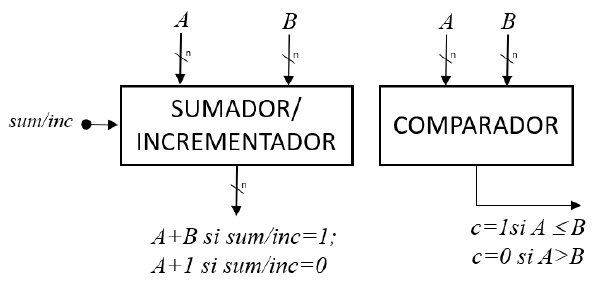

A continuación, tenéis el código que simulará estos dos recursos:

In [ ]:
class SumInc(Logic):
    """
    Configurable Incrementer/Adder

    a+b if sel = 1
    a+1 if sel = 0
    """

    def __init__(self, parent, name: str, a: Wire, b: Wire, sel: Wire, r: Wire):
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.b = self.addIn("b", b)
        self.sel = self.addIn("sum/inc", sel)
        self.r = self.addOut("r", r)
        
        self.one = Wire(self, "one", 1)
        self.muxOut = Wire(self, "muxOut", b.getWidth())

        Constant(self, "1", 1, self.one)

        self.mux = Mux2(self, "mux", sel, self.one, b, self.muxOut)
        self.add = Add(self, "add", a, self.muxOut, r)

In [ ]:
class LEQ(Logic):
    """
    Less or Equal comparator.

    c = 1 if a <= b
    c = 0 otherwise
    """

    def __init__(self, parent, name: str, a: Wire, b: Wire, c: Wire):
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.b = self.addIn("b", b)
        self.c = self.addOut("c", c)
        
        self.dummy = Wire(self, "", 1)
        self.eq = Wire(self, "equal", 1)
        self.lt = Wire(self, "less", 1)
    
        Comparator(self, "comparator", a, b, self.dummy, self.eq, self.lt)
        Or(self, "or", self.eq, self.lt, c) 

Finalmente, para permitir el encaminamiento de datos, vamos a utilizar una <u>estructura basada en buses</u>, más flexible, aunque frecuentemente más lenta que la estructura basada en multiplexores. Introduciremos dos buses, el *BusA* y el *BusB*, que llevarán los operandos a las entradas de los recursos de cálculo (*BusA*), y que llevarán la salida del módulo SUMADOR/ INCREMENTADOR a los registros (*BusB*):

>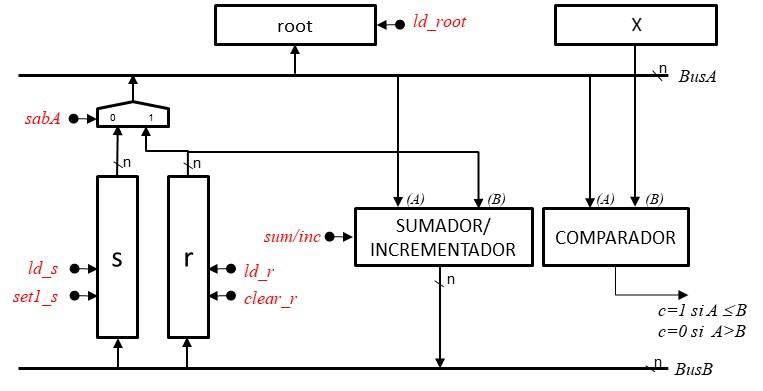

Esta unidad de proceso, donde el encaminamiento de los datos queda definido por dos buses en vez de multiplexores, requiere alguna explicación adicional:

1. *X* es un registro externo que guarda el valor del número *x* cuya raíz se desea calcular, y *root* es el registro donde finalmente se almacenará el resultado final del cálculo.

2. <u>Todos</u> los registros reciben la señal de reloj *CK*. Esta señal no se ha dibujado para no complicar innecesariamente el esquema.

3. Los registros *s* y *r* se han diseñado como registros de carga paralela síncrona, siendo *ld_s* y *ld_r* las señales de carga correspondientes (el registro se carga cuando llega un flanco de subida de *CK* y *ld_s* o *ld_r* está a 1).

4. La señal de control *clear_r* del registro *r* llega a la entrada asíncrona de Reset de los n flip flops del registro, forzándolos a 0 cuando *clear_r*=1. La señal *set1_s* del registro *s* está conectada a la entrada asíncrona de Reset de los n-1 flip flops más significativos, y a la entrada asíncrona de Set del flip flop menos significativo, de modo que cuando *set1_s=1*, los flip flops del registro s toman el valor 000…01.

5. El acceso a los buses puede controlarse de distintas maneras. Aquí se ha optado por utilizar un multiplexor de orden 1 y n bits de forma que, cuando la señal de control *sabA* (**s**eleccionar **a**cceso al **b**usA) toma el valor 0 el registro *s* queda conectado al *BusA*, y cuando *sabA*=1 el registro *r* queda conectado al *BusA*.


A continuación, tenéis el código que simulará la unidad de proceso:

In [ ]:
class ProcUnit(Logic):
    """
    Processing Unit for sqrt().
    """
    def __init__(self, parent, name:str, inic_rs:Wire, ld_s:Wire, ld_r:Wire, sabA:Wire, sum_inc:Wire,
        ld_root:Wire, X:Wire, rootOut:Wire, c:Wire):
        super().__init__(parent, name)

        # Init
        self.X = self.addIn(X.name, X)
        self.inic_rs = self.addIn(inic_rs.name, inic_rs)
        self.ld_s = self.addIn(ld_s.name, ld_s)
        self.ld_r = self.addIn(ld_r.name, ld_r)
        self.sabA = self.addIn(sabA.name, sabA)
        self.sum_inc = self.addIn(sum_inc.name, sum_inc)
        self.ld_root = self.addIn(ld_root.name, ld_root)

        self.rootOut = self.addOut(rootOut.name, rootOut)
        self.c = self.addOut(c.name, c)
       
        # Wires
        self.BusA = Wire(self, "BusA", 32)
        self.BusB = Wire(self, "BusB", 32)
        self.s2Mux = Wire(self, "s2Mux", 32)
        self.r2Mux = Wire(self, "r2Mux", 32)
        self.zero = Wire(self, "zero", 1)

        # Constants
        Constant(self, "0", 0, self.zero)

        # Muxes
        self.mux = Mux2(self, "muxA", self.sabA, self.s2Mux, self.r2Mux, self.BusA)

        # Registers
        self.root = Reg(self, "Root", self.BusA, self.ld_root, self.rootOut)
        self.s = RegSR(self, "S", self.BusB, self.ld_s, self.s2Mux, self.inic_rs, self.zero)
        self.r = RegSR(self, "R", self.BusB, self.ld_r, self.r2Mux, self.zero, self.inic_rs)

        # Logic Gates
        self.sum = SumInc(self, "Sum/Inc", self.BusA, self.r2Mux, self.sum_inc, self.BusB)
        self.comp = LEQ(self, "Comp", self.BusA, self.X, self.c)

## 2. Unidad de Control


***Insertar explicación y dibujos***


A continuación, tenéis el código que simulará la unidad de control:

In [ ]:
class CtrlUnit(Logic):
    """
    Control Unit for sqrt().
    """
    def __init__(self, parent, name:str, c:Wire, inicio:Wire, 
        inic_rs:Wire, ld_s:Wire, ld_r:Wire, sabA:Wire, sum_inc:Wire, ld_root:Wire, fin:Wire):
        super().__init__(parent, name)

        # Init
        self.c = self.addIn(c.name, c)
        self.inicio = self.addIn(inicio.name, inicio)

        self.inic_rs = self.addOut(inic_rs.name, inic_rs)
        self.ld_s = self.addOut(ld_s.name, ld_s)
        self.ld_r = self.addOut(ld_r.name, ld_r)
        self.sabA = self.addOut(sabA.name, sabA)
        self.sum_inc = self.addOut(sum_inc.name, sum_inc)
        self.ld_root = self.addOut(ld_root.name, ld_root)
        self.fin = self.addOut(fin.name, fin)
        
        # Wires
        self.cmpOut = Wire(self, "cmpOut", 3)
        self.startOut = Wire(self, "startOut", 3)
        self.muxOut = Wire(self, "MuxOut", 3)

        self.current_state = Wire(self, "CurrentState", 3)

        self.eWire = Wire(self, "enableWire", 1)
        
        self.inic_rs_mid = Wire(self, "inic_rs_mid", 1)
        self.ld_r_mid = Wire(self, "ld_r_mid", 1)
        self.ld_s_mid = Wire(self, "ld_s_mid", 1)
        self.ld_root_mid = Wire(self, "ld_root_mid", 1)
        self.fin_mid = Wire(self, "fin_mid", 1)

        # Constants
        self.one = Constant(self, "one", 1, self.eWire)

        # Wire Bundles
        self.state_wires = self.wires("state_wire", 8, 3)
        for i, wire in enumerate(self.state_wires):
            Constant(self, f"{i:b}", i, wire)

        self.q = self.wires("q", 3, 1)
        self.q_not = self.wires("qNot", 3, 1)
        Bits(self, "state2q", self.current_state, self.q)
        for i, wire in enumerate(self.q):
            Not(self, f"not{i}", wire, self.q_not[i])

        # Muxes
        self.cmpMux = Mux2(self, "cmpMux", self.c, 
            self.state_wires[0b111], self.state_wires[0b011], self.cmpOut)

        self.startMux = Mux2(self, "startMux", self.inicio, 
            self.state_wires[0b000], self.state_wires[0b001], self.startOut)

        self.muxIn = [self.startOut,
                    self.state_wires[0b010],
                    self.cmpOut,
                    self.state_wires[0b100],
                    self.state_wires[0b101],
                    self.state_wires[0b110],
                    self.state_wires[0b010],
                    self.state_wires[0b000]]
        self.mux = Mux(self, "MainMux", self.current_state, self.muxIn, self.muxOut)

        # Registers
        self.state_reg = Reg(self, "Estado", self.muxOut, self.eWire, self.current_state)

        # Logic Gates
        And(self, "inic_rs0", self.q_not[2], self.q_not[1], self.inic_rs_mid)
        And(self, "inic_rs1", self.inic_rs_mid, self.q[0], self.inic_rs)

        Or(self, "ld_s0", self.q_not[1], self.q_not[0], self.ld_s_mid)
        And(self, "ld_s1", self.ld_s_mid, self.q[2], self.ld_s)

        And(self, "ld_r0", self.q_not[2], self.q[1], self.ld_r_mid)
        And(self, "ld_r1", self.ld_r_mid, self.q[0], self.ld_r)

        And(self, "sabA0", self.q[1], self.q[0], self.sabA)

        Xor(self, "sum/inc0", self.q[1], self.q[0], self.sum_inc)

        And(self, "ld_root0", self.q[2], self.q[1], self.ld_root_mid)
        And(self, "ld_root1", self.ld_root_mid, self.q[0], self.ld_root)

        And(self, "fin0", self.q_not[2], self.q_not[1], self.fin_mid)
        And(self, "fin1", self.fin_mid, self.q_not[0], self.fin)

## 3. TestBench

In [ ]:
sys = HWSystem()

inic_rs = sys.wire("inic_rs")
ld_s = sys.wire("ld_s")
ld_r = sys.wire("ld_r") 
sabA = sys.wire("sabA")
sum_inc = sys.wire("sum_inc")
ld_root = sys.wire("ld_root")
X = sys.wire("X", 32)
root = sys.wire("root", 32)
c = sys.wire("c")
inicio = sys.wire("inicio")
fin = sys.wire("fin")

Constant(sys, "X", 25, X)
Constant(sys, "Inicio", 1, inicio)

proc = ProcUnit(sys, "UP", inic_rs, ld_s, ld_r, sabA, sum_inc, ld_root, X, root, c)
ctrl = CtrlUnit(sys, "UC", c, inicio, inic_rs, ld_s, ld_r, sabA, sum_inc, ld_root, fin)

state_wf = Waveform(sys, "State", ctrl.current_state)
root_wf = Waveform(sys, "Root", root)
s_wf = Waveform(sys, "S", proc.s2Mux)
r_wf = Waveform(sys, "R",  proc.r2Mux)
si_wf = Waveform(sys, "Sum/Inc",  sum_inc)

#py4hw.debug.printHierarchyWithValues(sys)

sim = sys.getSimulator()


while root.get() == 0:
  sim.clk(1)

draw(sim.get_waveform("Diagrama"))